# Homework 3 Group 40

## Imports

In [16]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

## Onehotencoding

In [17]:
def onehotify(input, label):
    # Replace Characters with numbers
    vocab = {"A":"1", "C": "2", "G":"3", "T":"0"}
    for key in vocab.keys():
        input = tf.strings.regex_replace(input, key, vocab[key])
    split = tf.strings.bytes_split(input)
    # Convert number-characters to integer values
    labels = tf.cast(tf.strings.to_number(split), tf.uint8)
    # Onehot encode our input- and target-data and reshape to correct shape
    onehot = tf.one_hot(labels, 4)
    onehot = tf.reshape(onehot, (-1,1000))
    label = tf.one_hot(label, 10)
    label = tf.reshape(label,(-1,10))
    return onehot, label

## Data Gathering and Input-Pipeline

In [18]:
# Load the Dataset and split it into training and testing data
train_data, test_data = tfds.load("genomics_ood", split = ['train[:100000]', 'test[:1000]'], as_supervised = True)

# Give Our data the desired properties
train_data = train_data.map(onehotify)
test_data = test_data.map(onehotify)
# Inputpipeline --> shuffle our datasets on the start of each Epoch, Batch and the prefetch for faster computation
train_data =   (tf.data.Dataset.shuffle(train_data,buffer_size = 100000, reshuffle_each_iteration=True).batch(40).prefetch(40))
test_data = (tf.data.Dataset.shuffle(test_data,buffer_size = 10000, reshuffle_each_iteration=True).batch(40).prefetch(40))


## Defining our Model

In [19]:
class MLP(Model):
    
    def __init__(self):
        # inherit information from the higher class
        super(MLP, self).__init__()
        
        # implement the 2 hidden layers with 256 units and sigmoid as activation function
        self.hidden_layer1 = tf.keras.layers.Dense(units = 256, activation = tf.keras.activations.sigmoid)
        self.hidden_layer2 = tf.keras.layers.Dense(units = 256, activation = tf.keras.activations.sigmoid)
        
        # implement the output layer with 10 units and the softmax activation function
        self.output_layer = tf.keras.layers.Dense(units = 10, activation = tf.keras.activations.softmax)
    
    # define the forward step for the model
    def call(self, x):
        x = self.hidden_layer1(x)
        x = self.hidden_layer2(x)
        x = self.output_layer(x)
        return x

## Trainingstep

In [20]:
def train_step(model, input, target, loss_function, optimizer):
    with tf.GradientTape() as tape:
        expectation = model(input)
        train_accuracy =  np.argmax(target, axis = 2) == np.argmax(expectation, axis = 2)
        loss = loss_function(target, expectation)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, train_accuracy

## Teststep

In [21]:
def test(model, test_data, loss_function):
    test_accuracies_total = []
    test_losses_total = []
    # Compute and return loss and accuracy of Test-data
    for (input, target) in test_data:
        expectation = model(input)
        test_loss = loss_function(target, expectation)
    # compare if our target equals the correct classification
        test_accuracy =  np.argmax(target, axis = 2) == np.argmax(expectation, axis = 2)
        test_accuracy = np.mean(test_accuracy)
        test_accuracies_total.append(test_accuracy)
        test_losses_total.append(test_loss)
    
    # take the mean of all losses and all accuracies to get them for the whole test
    test_losses_total = np.mean(test_losses_total)
    test_accuracies_total = np.mean(test_accuracies_total)
    return test_losses_total, test_accuracies_total

## Training our model for 10 epochs

In [22]:
# define fixed parameters
num_epochs = 10
learning_rate = 0.1
# use categorical cross entropy as loss function
loss_function = tf.keras.losses.CategoricalCrossentropy()
# use SGD as optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate)
# initialize the model
model = MLP()

# lists for plotting later
test_loss_list = []
test_accuracy_list = []

train_loss_list = []
train_accuracy_list = []


# get loss on train data before training
train_loss, train_accuracy = test(model, train_data, loss_function)
train_loss_list.append(train_loss)
train_accuracy_list.append(train_accuracy)

# test once before training
test_loss, test_accuracy = test(model, test_data, loss_function)
test_loss_list.append(test_loss)
test_accuracy_list.append(test_accuracy)


# we train for the predefined number of epochs
for step in range(num_epochs):
    # reset average for each step
    changing_average = []
    train_accuracy_agg = []
    # train the model with the training data
    for (input, target) in train_data:
    # perform training step and store the loss and accuracy of step
        train_loss, train_accuracy = train_step(model, input, target, loss_function, optimizer)
        changing_average.append(train_loss)
        train_accuracy_agg.append(train_accuracy)

    # compute mean loss and accuracy of trainingcycle
    train_loss_list.append(np.mean(changing_average))
    train_accuracy_list.append(np.mean(train_accuracy_agg))
    
    # test on the test data
    test_loss, test_accuracy = test(model, test_data, loss_function)
    test_loss_list.append(test_loss)
    test_accuracy_list.append(test_accuracy)
    print(step)

0
1
2
3
4
5
6
7
8
9


## Plot the results

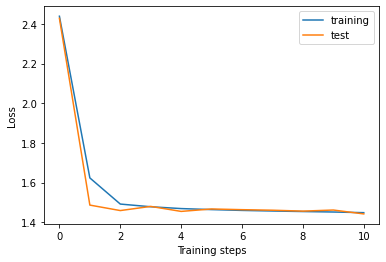

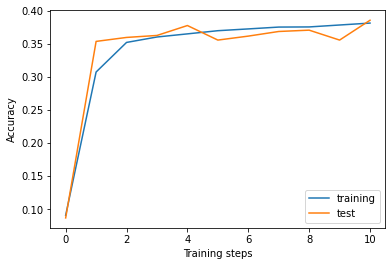

In [25]:
# Plot Figure displaying test and training loss for each epoch
plt.figure()
line1, = plt.plot(train_loss_list)
line2, = plt.plot(test_loss_list)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

# Plot Figure displaying test and training accuracy for each epoch
plt.figure()
line1, = plt.plot(train_accuracy_list)
line2, = plt.plot(test_accuracy_list)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.legend((line1,line2),("training","test"))
plt.show()